## Load Packages

In [32]:
!pip install gradio

  Using cached aiofiles-23.2.1-py3-none-any.whl.metadata (9.7 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 0.0/50.9 kB ? eta -:--:--
     ---------------------------------------- 50.9/50.9 kB 2.5 MB/s eta 0:00:00
     ---------------------------------------- 0.0/107.3 kB ? eta -:--:--
     ------------------------------------ - 102.4/107.3 kB 2.0 MB/s eta 0:00:01
     -------------------------------------- 107.3/107.3 kB 2.1 MB/s eta 0:00:00
  Using cached tomlkit-0.12.0-py3-none-any.whl.metadata (2.7 kB)
  Using cached fsspec-2024.3.1-py3-none-any.whl.metadata (6.8 kB)
     ---------------------------------------- 0.0/57.6 kB ? eta -:--:--
     ---------------------------------------- 57.6/57.6 kB ? eta 0:00:00
  Using cached annotated_types-0.6.0-py3-none-any.whl.metadata (12 kB)
  Using cached shellingham-1.5.4-py2.py3-none-any.whl.metadata (3.5 kB)
  Using cached rich-13.7.1-p

In [ ]:
!conda install ipywidgets -y

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras.backend as K
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import f1_score

## Load Data

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [3]:
emotion_label = {0: 'Anger', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

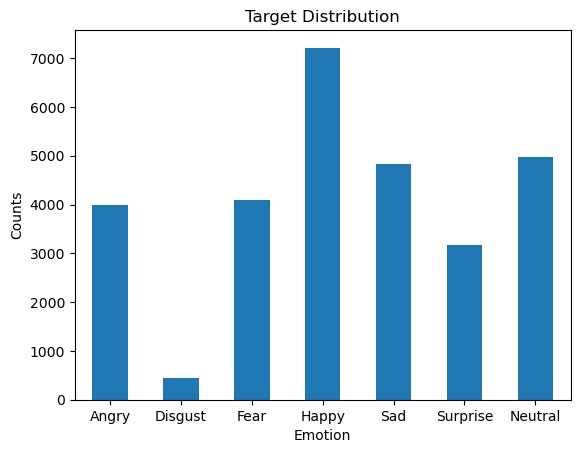

In [4]:
# storing emotion labels
label_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# calculating target distribution
td = train_df["emotion"].value_counts().sort_index()

# plotting
td.plot(kind='bar')
plt.title('Target Distribution')
plt.xlabel('Emotion')
plt.ylabel('Counts')
plt.xticks(ticks=range(len(label_names)), labels=label_names, rotation=0)
plt.show()

## Sampling Data

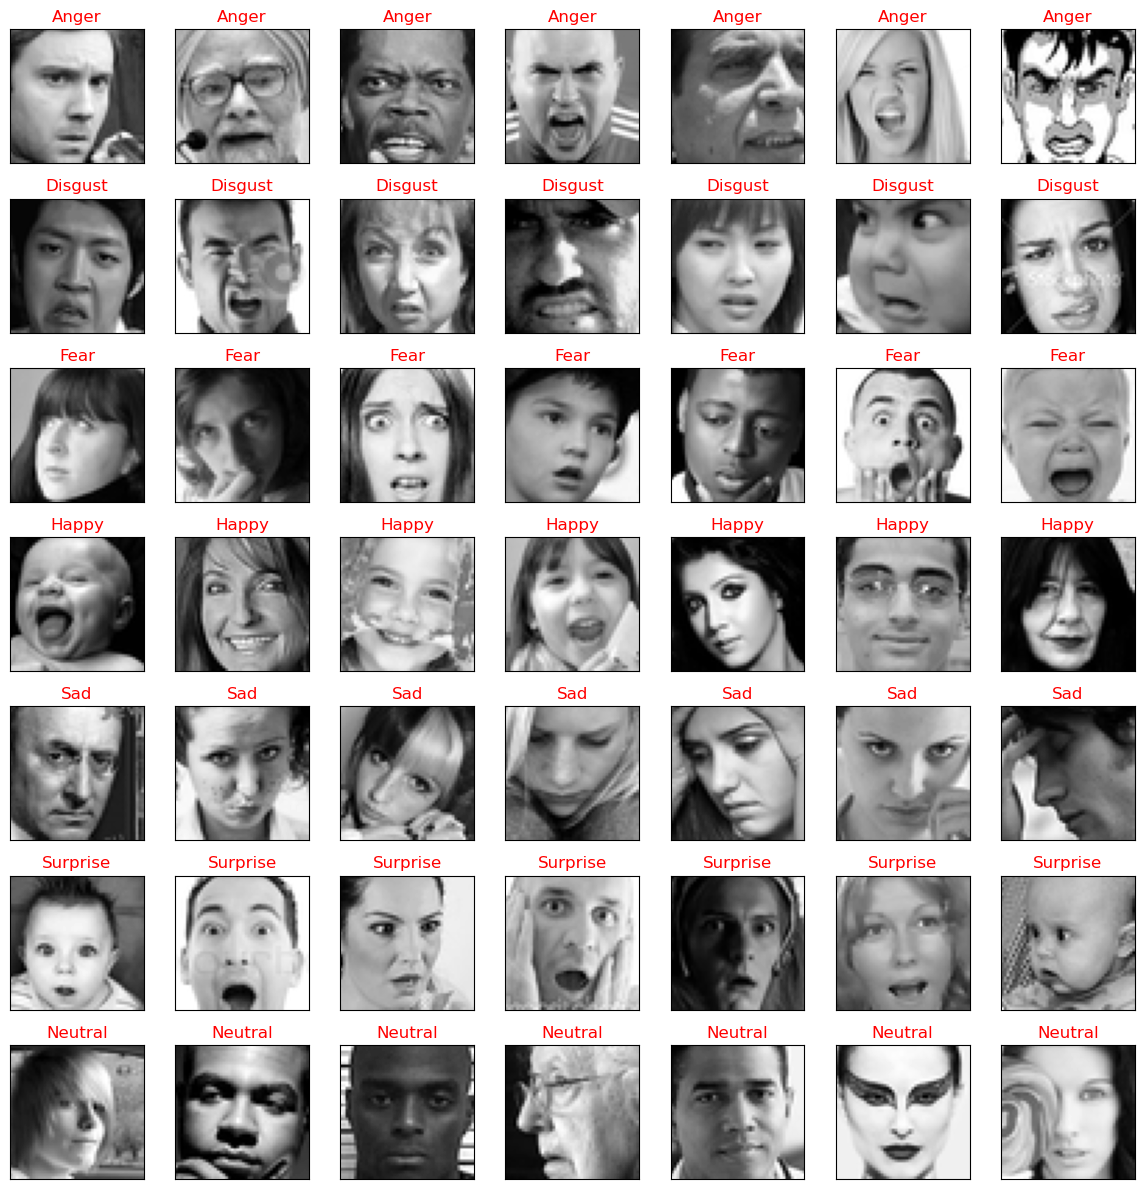

In [5]:
fig = plt.figure(1, (12,12))
k=0

for label in sorted(train_df.emotion.unique()):
    for j in range(7):
        px = train_df[train_df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48,48).astype('float32')
        
        k += 1
        ax = plt.subplot(7,7,k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label[label]).set_color('Red')
        plt.tight_layout()

In [23]:
# Define ImageDataGenerator for training data with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,                    # Rescale pixel values to [0, 1]
    validation_split=0.2,              # Splitting data into training and validation sets
    rotation_range=5,                  # Rotate images randomly up to 5 degrees
    width_shift_range=0.2,             # Shift images horizontally up to 20% of the width
    height_shift_range=0.2,            # Shift images vertically up to 20% of the height
    shear_range=0.2,                   # Shear images by 2
    horizontal_flip=True,              # Flip images horizontally
    vertical_flip=True,                # Flip images vertically
    fill_mode='nearest'                # Fill in newly created pixels after rotation or shifting
)

# Define ImageDataGenerator for validation data
valid_datagen = ImageDataGenerator(
    rescale=1./255,                    # Rescale pixel values to [0, 1]
    validation_split=0.2               # Splitting data into training and validation sets
)

# Define ImageDataGenerator for test data
test_datagen = ImageDataGenerator(rescale=1./255)  # Rescale pixel values to [0, 1]


In [24]:
train_dataset  = train_datagen.flow_from_directory(directory = 'train',
                                                   target_size = (48,48),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 64)

Found 22968 images belonging to 7 classes.


In [25]:
valid_dataset = valid_datagen.flow_from_directory(directory = 'train',
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 64)

Found 5741 images belonging to 7 classes.


In [26]:
test_dataset = test_datagen.flow_from_directory(directory = 'test',
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  batch_size = 64)

Found 7178 images belonging to 7 classes.


(48, 48, 3)
(1, 48, 48, 3)


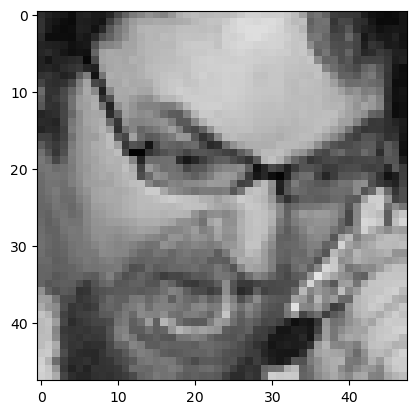

In [27]:
from tensorflow.keras.preprocessing import image
img = image.load_img("test/angry/PrivateTest_10131363.jpg",target_size=(48,48))
img = np.array(img)
plt.imshow(img)
print(img.shape)
img = np.expand_dims(img, axis=0)
from keras.models import load_model
print(img.shape)

## Build Network

In [28]:
base_model = tf.keras.applications.ResNet50(input_shape=(48,48,3),include_top=False,weights="imagenet")

In [29]:
# Freezing Layers
for layer in base_model.layers[:-4]:
    layer.trainable=False

In [30]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(7,activation='softmax'))

In [31]:
# Model Summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 dropout_3 (Dropout)         (None, 2, 2, 2048)        0         
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 batch_normalization_4 (Batc  (None, 8192)             32768     
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 32)                262176    
                                                                 
 batch_normalization_5 (Batc  (None, 32)               128       
 hNormalization)                                      

## Train Network

In [32]:
# Early Stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [33]:
opt = tf.keras.optimizers.Adam(learning_rate = 0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

## Train Run 1

In [34]:
def f1_metric(y_true, y_pred):
    y_pred = K.round(y_pred)
    return f1_score(y_true, y_pred, average='micro')

In [35]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [36]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [37]:
# It is a callback used to reduce the learning rate when a metric has stopped improving.Verbose = print a message or no
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 20,verbose = 1,factor = 0.50, min_lr = 1e-10)

# Stop training if not improving
es = EarlyStopping(verbose=1, patience=20)

In [38]:
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)

In [39]:
h1 = model.fit(train_dataset,validation_data=valid_dataset,epochs = 30,callbacks=[lrd,es])

Epoch 1/30
359/359 [==============================] - 194s 517ms/step - loss: 1.9393 - accuracy: 0.8544 - precision: 0.1429 - recall: 0.0039 - auc: 0.5970 - f1_score: 0.0074 - val_loss: 1.8612 - val_accuracy: 0.8570 - val_precision: 0.2222 - val_recall: 3.4837e-04 - val_auc: 0.6198 - val_f1_score: 6.8376e-04 - lr: 0.0010
Epoch 2/30
359/359 [==============================] - 162s 450ms/step - loss: 1.8313 - accuracy: 0.8568 - precision: 0.1978 - recall: 7.8370e-04 - auc: 0.6377 - f1_score: 0.0015 - val_loss: 1.8175 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6477 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 3/30
359/359 [==============================] - 160s 446ms/step - loss: 1.8213 - accuracy: 0.8570 - precision: 0.0800 - recall: 8.7078e-05 - auc: 0.6409 - f1_score: 1.7142e-04 - val_loss: 1.8166 - val_accuracy: 0.8570 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6515 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 4/30


In [40]:
model.save("model.h5")

In [41]:
history = h1.history
print(history.keys())

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'auc', 'f1_score', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_auc', 'val_f1_score', 'lr'])


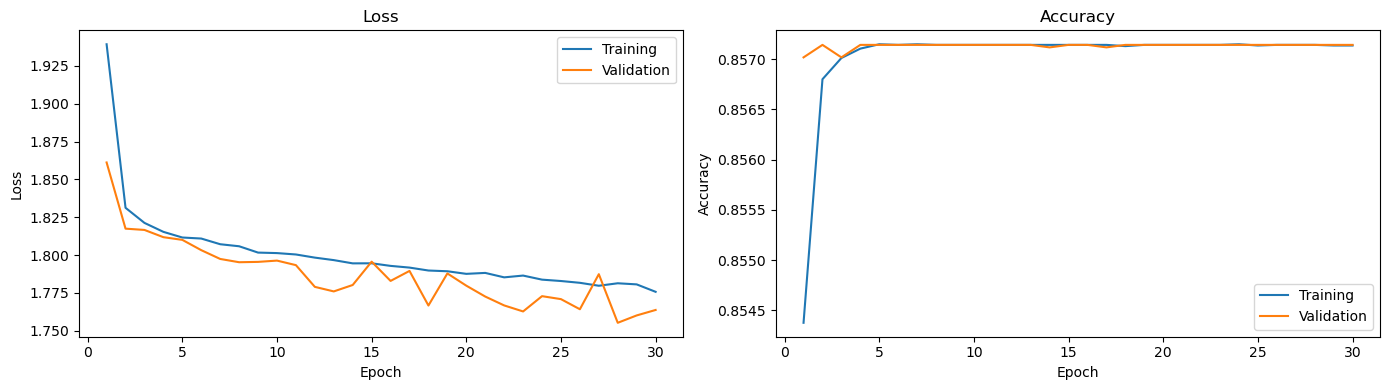

In [42]:
epoch_range = range(1, len(history['loss'])+1)

plt.figure(figsize=[14,4])
plt.subplot(1,2,1)
plt.plot(epoch_range, history['loss'], label='Training')
plt.plot(epoch_range, history['val_loss'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epoch_range, history['accuracy'], label='Training')
plt.plot(epoch_range, history['val_accuracy'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [43]:
test_loss, test_accuracy, test_precision, test_recall, test_auc, test_f1_score = model.evaluate(test_dataset)

# Print the test accuracy
print("Test Accuracy:", test_accuracy)
print("Test Loss:",test_loss)

113/113 [==============================] - 39s 340ms/step - loss: 1.7649 - accuracy: 0.8571 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6867 - f1_score: 0.0000e+00
Test Accuracy: 0.8571428656578064
Test Loss: 1.764944076538086


In [ ]:
from sklearn.metrics import confusion_matrix

# Get true labels and predicted labels for all images in the test dataset
true_labels = []
predicted_labels = []

for images, labels in test_dataset:
    predictions = model.predict(images)
    predicted_emotions = np.argmax(predictions, axis=1)
    true_labels.extend(np.argmax(labels, axis=1))
    predicted_labels.extend(predicted_emotions)

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels.values(), yticklabels=class_labels.values())
plt.xlabel('Predicted Emotion')
plt.ylabel('True Emotion')
plt.title('Confusion Matrix')
plt.show()

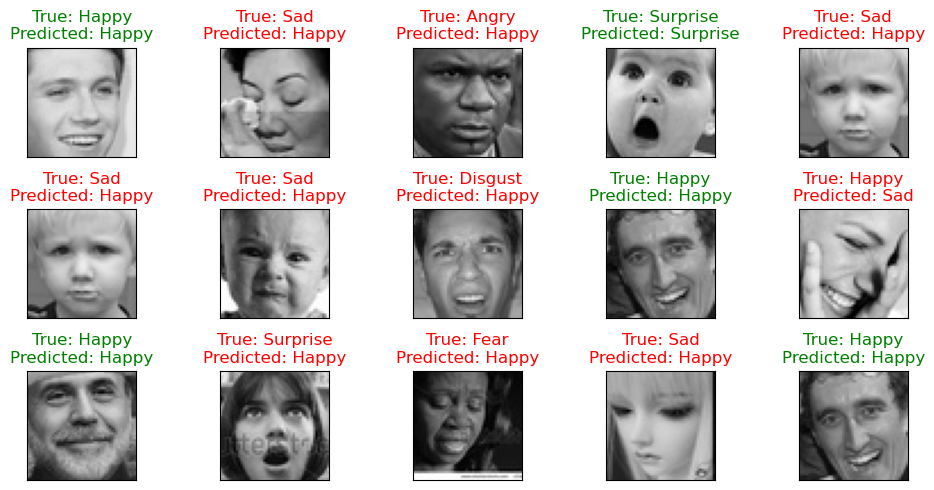

In [47]:
# Emotion classes for the dataset
Emotion_Classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

# Assuming test_generator and model are already defined
batch_size = test_dataset.batch_size

# Selecting a random batch from the test generator
Random_batch = np.random.randint(0, len(test_dataset) - 1)

# Selecting random image indices from the batch
Random_Img_Index = np.random.randint(0, batch_size, 15)

# Setting up the plot
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(10, 5),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    # Fetching the random image and its label
    Random_Img = test_dataset[Random_batch][0][Random_Img_Index[i]]
    Random_Img_Label = np.argmax(test_dataset[Random_batch][1][Random_Img_Index[i]], axis=0)

    # Making a prediction using the model
    Model_Prediction = np.argmax(model.predict(tf.expand_dims(Random_Img, axis=0), verbose=0), axis=1)[0]

    # Displaying the image
    ax.imshow(Random_Img.squeeze(), cmap='gray')  # Assuming the images are grayscale
    # Setting the title with true and predicted labels, colored based on correctness
    color = "green" if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction] else "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)

plt.tight_layout()
plt.show()

2/2 [==============================] - 0s 83ms/step
64


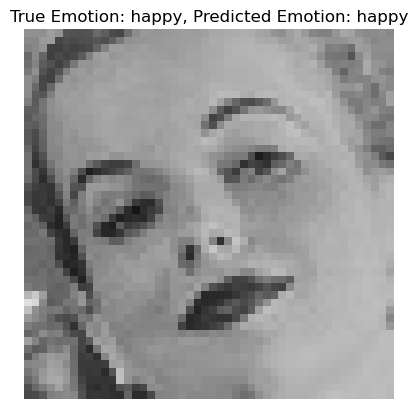

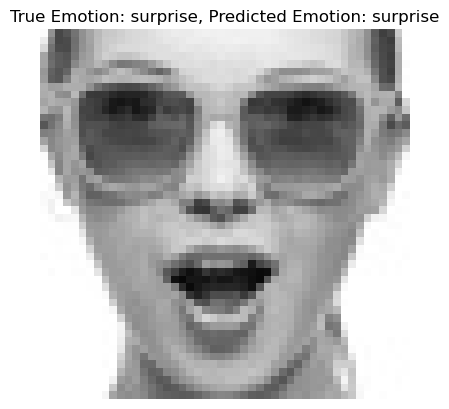

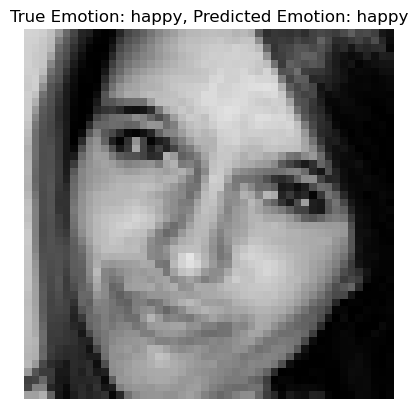

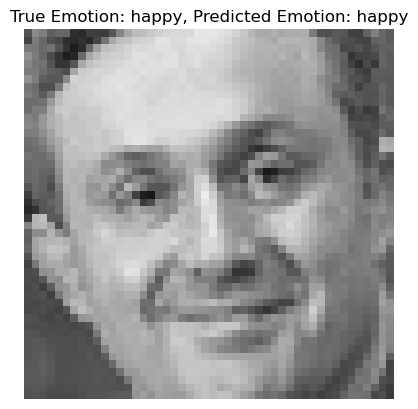

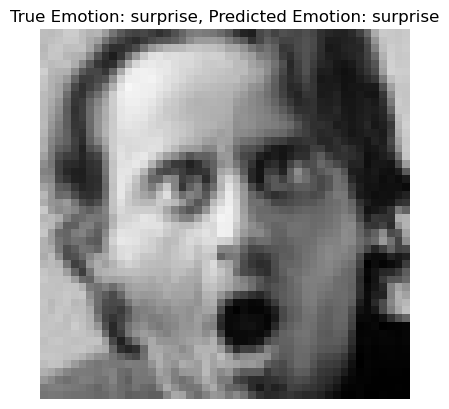

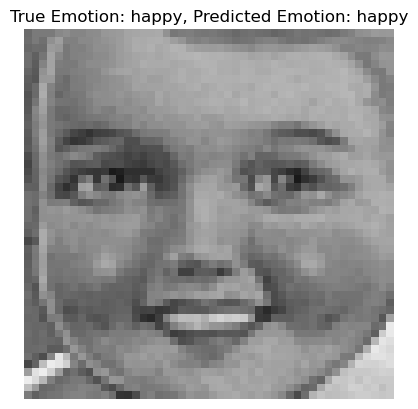

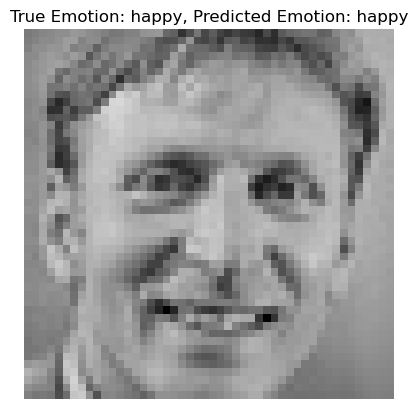

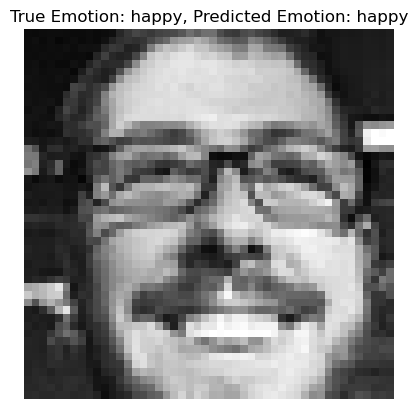

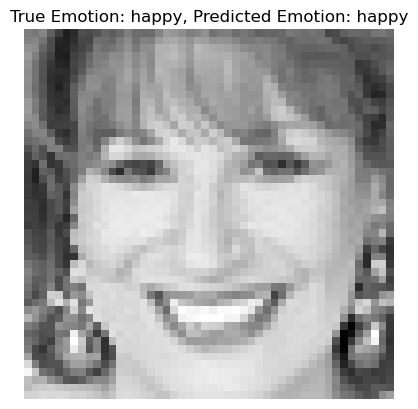

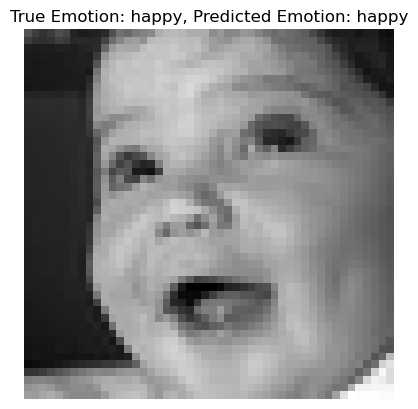

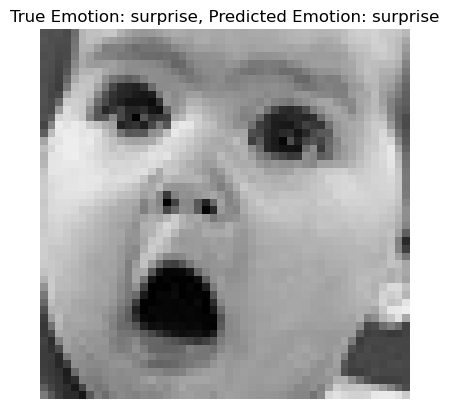

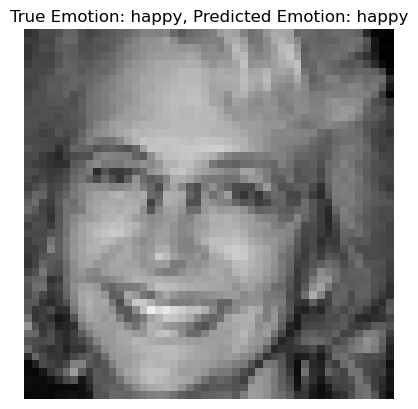

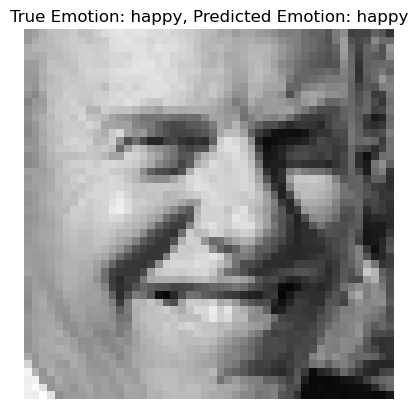

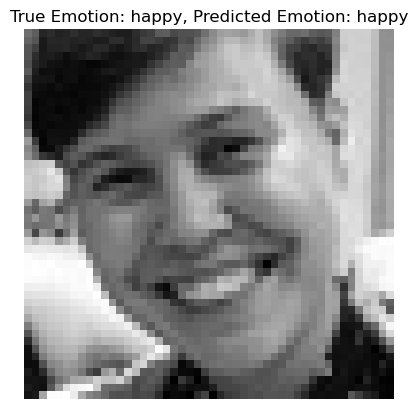

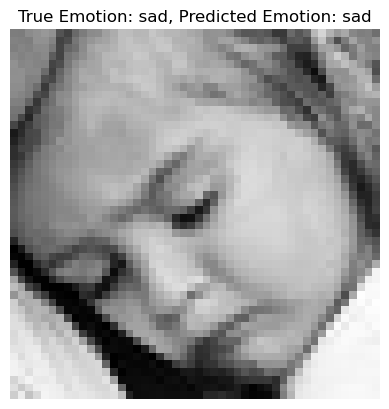

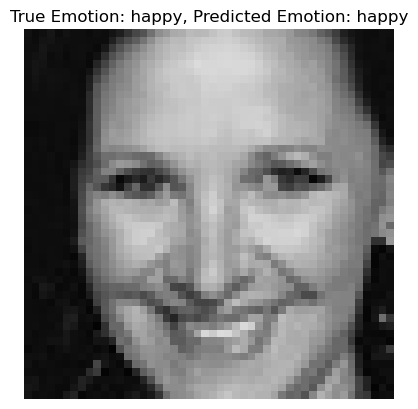

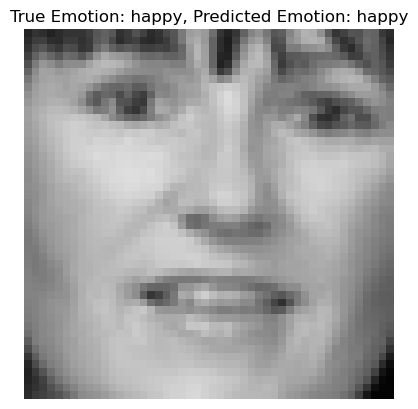

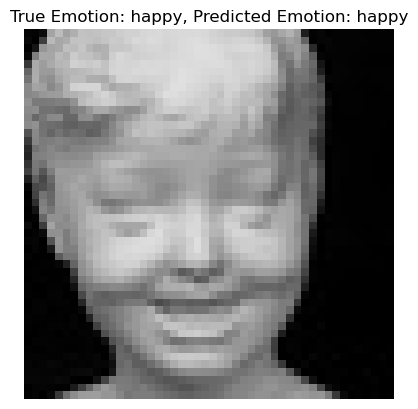

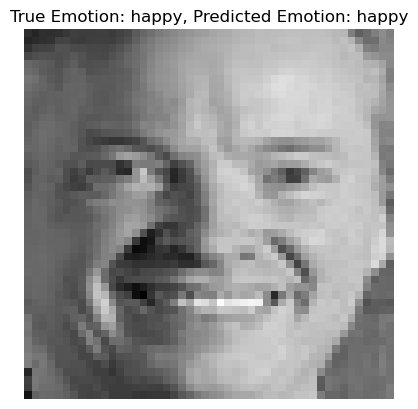

19


In [49]:
# Iterate over the test dataset
for images, labels in test_dataset:
    # Predict emotions for the batch of images
    predictions = model.predict(images)
    # Get the index of the predicted emotion (class) for each image
    predicted_emotions = np.argmax(predictions, axis=1)
    # Get class labels from the dataset
    class_labels = test_dataset.class_indices
    
    # Inverse mapping to get emotion labels from class indices
    emotion_labels = {value: key for key, value in class_labels.items()}
    print(len(images))
    coun = 0
    # Plot each image with its predicted emotion
    for i in range(len(images)):
        # Get the image and its label
        image = images[i]
        true_emotion = emotion_labels[np.argmax(labels[i])]
        predicted_emotion = emotion_labels[predicted_emotions[i]]
        
        if(true_emotion == predicted_emotion):
            coun = coun + 1
            # Plot the image with its true and predicted emotion
            plt.imshow(image)
            plt.title(f'True Emotion: {true_emotion}, Predicted Emotion: {predicted_emotion}')
            plt.axis('off')
            plt.show()
    print(coun)
    # Break after plotting the first batch to avoid plotting all images in the dataset
    break


In [51]:
import gradio as gr

In [52]:
def classify(inp):
    print(inp.shape)
    inp = inp.reshape(-1,48,48,3)
    predictions = model.predict(inp).flatten()
    return {label_names[i]: float(predictions[i]) for i in range(7)}
image = gr.Image(width=480,height=480)
label = gr.Label(num_top_classes=3)

In [53]:
iface = gr.Interface(fn=classify, inputs=image, outputs=label)
iface.launch()

Running on local URL:  http://127.0.0.1:7864

To create a public link, set `share=True` in `launch()`.
